In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from category_encoders import TargetEncoder
import warnings

In [40]:
X=pd.read_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\X.csv')
Y=pd.read_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\Y.csv')
X_ENERGYSTARScore=pd.read_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\X_ENERGYSTARScore.csv')
Y_ENERGYSTARScore=pd.read_csv(r'C:\Users\Kfoury\Desktop\Besoin electrique\Y_ENERGYSTARScore.csv')

## Feature Names function

https://johaupt.github.io/blog/columnTransformer_feature_names.html

In [41]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Without EnergyStarScore

## Train test split

In [114]:
# Numerical features
numeric_features = ['PropertyGFATotal', 'RelPropertyGFAParking','RelPropertyGFABuilding(s)',
                    'PropertyGFATotalPerBuild','PropertyGFATotalPerFloor',
                    'Distance_From_Center','Age','NumberofFloors','NumberofBuildings']
numeric_transformer = Pipeline(
                      steps=[("scaler", RobustScaler())]
                              )

# Categorical features
categorical_features = ['Neighborhood','CouncilDistrictCode','BuildingType','PrimaryPropertyType']
categorical_transformer =TargetEncoder()
preprocessor = ColumnTransformer(
                                 transformers=[
                                               ("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features),
                                              ]
                                )

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Dummy Regression

In [43]:
Transformed_DR=TransformedTargetRegressor(
                               regressor=DummyRegressor(), 
                                func=np.log, 
                               inverse_func=np.exp)
pipeline_DR = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Transformed_DR)]   
                      )

parameters_DR ={}
parameters_DR['model__regressor__strategy']=('mean','median')


search_DR=GridSearchCV(pipeline_DR,parameters_DR, scoring=('r2','neg_mean_squared_error'), cv=5,refit='neg_mean_squared_error')

### SiteEnergyUse(kBtu)

In [318]:
Dummy_SEU=search_DR.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

print('neg_mean_squared_error: %.3f' % Dummy_SEU.best_score_)
print('r2_score:',pd.DataFrame(Dummy_SEU.cv_results_)[pd.DataFrame(Dummy_SEU.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -91040675282100.328
r2_score: 0   -0.115669
Name: mean_test_r2, dtype: float64


In [320]:
 Dummy_SEU.best_params_

{'model__regressor__strategy': 'mean'}

###  TotalGHGEmissions

In [321]:
Dummy_GHG=search_DR.fit(X_train, y_train['TotalGHGEmissions'])

print('neg_mean_squared_error: %.3f' % Dummy_GHG.best_score_)
print('r2_score:',pd.DataFrame(Dummy_GHG.cv_results_)[pd.DataFrame(Dummy_GHG.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -25349.654
r2_score: 1   -0.160079
Name: mean_test_r2, dtype: float64


In [322]:
 Dummy_GHG.best_params_

{'model__regressor__strategy': 'median'}

## Linear Regression

In [46]:
Transformed_LR=TransformedTargetRegressor(
                               regressor=LinearRegression(), 
                                func=np.log, 
                               inverse_func=np.exp)
pipeline_LR = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Transformed_LR)]   
                      )

parameters_LR ={}
parameters_LR['model__regressor__fit_intercept']=(True,False)
parameters_LR['model__regressor__normalize']=(True,False)


search_LR=GridSearchCV(pipeline_LR,parameters_LR, scoring=('r2','neg_mean_squared_error'), cv=5,refit='neg_mean_squared_error')

### SiteEnergyUse(kBtu)

In [327]:
Linear_SEU=search_LR.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

print('neg_mean_squared_error: %.3f' % Linear_SEU.best_score_)
print('r2_score:',pd.DataFrame(Linear_SEU.cv_results_)[pd.DataFrame(Linear_SEU.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -5037768350524413.000
r2_score: 0   -46.350076
Name: mean_test_r2, dtype: float64


In [328]:
Linear_SEU.best_params_

{'model__regressor__fit_intercept': True, 'model__regressor__normalize': True}

###  TotalGHGEmissions

In [325]:
Linear_GHG=search_LR.fit(X_train, y_train['TotalGHGEmissions'])

print('neg_mean_squared_error: %.3f' % Linear_GHG.best_score_)

print('r2_score:',pd.DataFrame(Linear_GHG.cv_results_)[pd.DataFrame(Linear_GHG.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -351146.514
r2_score: 2   -12.606732
Name: mean_test_r2, dtype: float64


In [326]:
Linear_GHG.best_params_

{'model__regressor__fit_intercept': False, 'model__regressor__normalize': True}

## Elastic Net

In [49]:
Transformed_EN=TransformedTargetRegressor(
                               regressor=ElasticNet(), 
                                func=np.log, 
                               inverse_func=np.exp)
pipeline_EN = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Transformed_EN)]   
                      )

parameters_EN ={}
#parameters_EN['model__regressor__alpha'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0]
#parameters_EN['model__regressor__l1_ratio']=[0,0.5,1]
parameters_EN['model__regressor__fit_intercept']=(True,False)
#parameters_EN['model__regressor__max_iter']=[10000]

search_EN=GridSearchCV(pipeline_EN,parameters_EN, scoring=('r2','neg_mean_squared_error'), cv=5,refit='neg_mean_squared_error')

### SiteEnergyUse(kBtu)

In [305]:
Elastic_SEU=search_EN.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

print('neg_mean_squared_error: %.3f' % Elastic_SEU.best_score_)
print('Config: %s' % Elastic_SEU.best_params_)
print('r2_score:',pd.DataFrame(Elastic_SEU.cv_results_)[pd.DataFrame(Elastic_SEU.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -100842652489314.656
Config: {'model__regressor__fit_intercept': True}
r2_score: 0   -0.085081
Name: mean_test_r2, dtype: float64


###  TotalGHGEmissions

In [306]:
Elastic_GHG=search_EN.fit(X_train, y_train['TotalGHGEmissions'])

print('neg_mean_squared_error: %.3f' % Elastic_GHG.best_score_)
print('Config: %s' % Elastic_GHG.best_params_)
print('r2_score:',pd.DataFrame(Elastic_GHG.cv_results_)[pd.DataFrame(Elastic_GHG.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

neg_mean_squared_error: -20265.990
Config: {'model__regressor__fit_intercept': True}
r2_score: 0    0.075699
Name: mean_test_r2, dtype: float64


## Random Forest Regression

In [329]:
Transformed_RFR=TransformedTargetRegressor(
                               regressor=RandomForestRegressor(), 
                                func=np.log, 
                               inverse_func=np.exp)
pipeline_RFR = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Transformed_RFR)]   
                      )

parameters_RFR ={}
# Number of trees in random forest
#parameters_RFR['model__regressor__n_estimators'] = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
#parameters_RFR['model__regressor__max_features'] = ['auto', 'sqrt']
# Maximum number of levels in tree
parameters_RFR['model__regressor__max_depth'] = [int(x) for x in np.linspace(10, 50, num = 2)]
parameters_RFR['model__regressor__max_depth'].append(None)
# Minimum number of samples required to split a node
parameters_RFR['model__regressor__min_samples_split'] = [2, 5, 10]
# Minimum number of samples required at each leaf node
parameters_RFR['model__regressor__min_samples_leaf'] = [1, 2, 4]
# Method of selecting samples for training each tree
parameters_RFR['model__regressor__bootstrap'] = [True, False]



search_RFR=GridSearchCV(pipeline_RFR,parameters_RFR, scoring=('r2','neg_mean_squared_error'), cv=5,refit='neg_mean_squared_error')
#features_importance
#feature_importance = search_RFR.best_estimator_.regressor_.feature_importances
#search_RFR.best_estimator_.feature_name_in

### SiteEnergyUse(kBtu)

In [330]:
RandomForest_SEU=search_RFR.fit(X_train, y_train['SiteEnergyUse(kBtu)'])

print('neg_mean_squared_error: %.3f' % RandomForest_SEU.best_score_)
print('Config: %s' % RandomForest_SEU.best_params_)

neg_mean_squared_error: -30103697505502.688
Config: {'model__regressor__bootstrap': True, 'model__regressor__max_depth': 50, 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 10}


In [331]:
print('r2_score:',pd.DataFrame(RandomForest_SEU.cv_results_)[pd.DataFrame(RandomForest_SEU.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

r2_score: 11    0.628378
Name: mean_test_r2, dtype: float64


C:\Users\Kfoury\AppData\Local\Temp/ipykernel_2164/1809191144.py:30: UserWarning: Transformer scaler (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'num__PropertyGFATotal'),
  Text(1, 0, 'num__RelPropertyGFAParking'),
  Text(2, 0, 'num__RelPropertyGFABuilding(s)'),
  Text(3, 0, 'num__PropertyGFATotalPerBuild'),
  Text(4, 0, 'num__PropertyGFATotalPerFloor'),
  Text(5, 0, 'num__Distance_From_Center'),
  Text(6, 0, 'num__Age'),
  Text(7, 0, 'num__NumberofFloors'),
  Text(8, 0, 'num__NumberofBuildings'),
  Text(9, 0, 'cat__Neighborhood'),
  Text(10, 0, 'cat__CouncilDistrictCode'),
  Text(11, 0, 'cat__BuildingType'),
  Text(12, 0, 'cat__PrimaryPropertyType')])

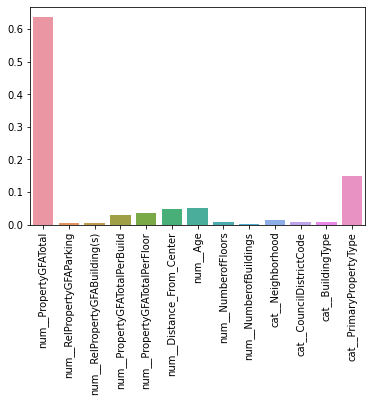

In [332]:
feature_importance =RandomForest_SEU.best_estimator_.named_steps['model'].regressor_.feature_importances_
feature_names=get_feature_names(RandomForest_SEU.best_estimator_.named_steps['preprocessor'])
sns.barplot(x=feature_names,y=feature_importance)
plt.xticks(rotation=90)

R2 Score: 0.19062070100252115
Mean squared error: 37318292810090.9


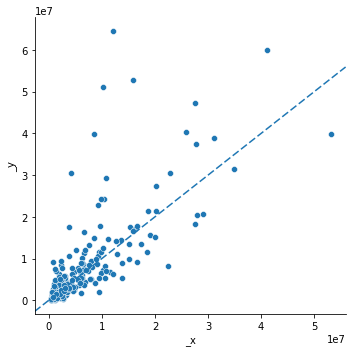

In [333]:
plot=sns.relplot(x=RandomForest_SEU.predict(X_test),y=y_test['SiteEnergyUse(kBtu)'].values)
plot.ax.axline(xy1=(0,0),slope=1,dashes=(5,2))
print('R2 Score:',r2_score(RandomForest_SEU.predict(X_test),y_test['SiteEnergyUse(kBtu)']))
print('Mean squared error:',mean_squared_error(RandomForest_SEU.predict(X_test),y_test['SiteEnergyUse(kBtu)']))


###  TotalGHGEmissions

In [334]:
RandomForest_GHG=search_RFR.fit(X_train, y_train['TotalGHGEmissions'])

print('neg_mean_squared_error: %.3f' % RandomForest_GHG.best_score_)
print('Config: %s' % RandomForest_GHG.best_params_)

neg_mean_squared_error: -12760.648
Config: {'model__regressor__bootstrap': True, 'model__regressor__max_depth': 50, 'model__regressor__min_samples_leaf': 2, 'model__regressor__min_samples_split': 2}


In [338]:
RandomForest_GHG.best_params_

{'model__regressor__bootstrap': True,
 'model__regressor__max_depth': 50,
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 2}

In [335]:
print('r2_score:',pd.DataFrame(RandomForest_GHG.cv_results_)[pd.DataFrame(RandomForest_GHG.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

r2_score: 12    0.411224
Name: mean_test_r2, dtype: float64


C:\Users\Kfoury\AppData\Local\Temp/ipykernel_2164/1809191144.py:30: UserWarning: Transformer scaler (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'num__PropertyGFATotal'),
  Text(1, 0, 'num__RelPropertyGFAParking'),
  Text(2, 0, 'num__RelPropertyGFABuilding(s)'),
  Text(3, 0, 'num__PropertyGFATotalPerBuild'),
  Text(4, 0, 'num__PropertyGFATotalPerFloor'),
  Text(5, 0, 'num__Distance_From_Center'),
  Text(6, 0, 'num__Age'),
  Text(7, 0, 'num__NumberofFloors'),
  Text(8, 0, 'num__NumberofBuildings'),
  Text(9, 0, 'cat__Neighborhood'),
  Text(10, 0, 'cat__CouncilDistrictCode'),
  Text(11, 0, 'cat__BuildingType'),
  Text(12, 0, 'cat__PrimaryPropertyType')])

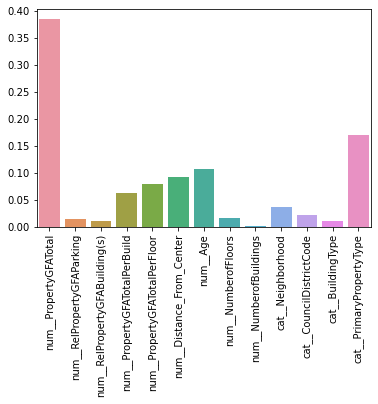

In [336]:
feature_importance = RandomForest_GHG.best_estimator_.named_steps['model'].regressor_.feature_importances_
feature_names=get_feature_names(RandomForest_GHG.best_estimator_.named_steps['preprocessor'])
sns.barplot(x=feature_names,y=feature_importance)
plt.xticks(rotation=90)

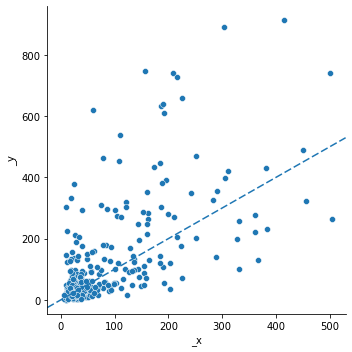

In [337]:
plot=sns.relplot(x=RandomForest_GHG.predict(X_test),y=y_test['TotalGHGEmissions'].values)
plot.ax.axline(xy1=(0,0),slope=1,dashes=(5,2))

# With EnergyStarScore

## Train Test Split 

In [254]:
Transformed_RFR_EN=TransformedTargetRegressor(
                               regressor=RandomForestRegressor(), 
                                func=np.log, 
                               inverse_func=np.exp)
pipeline_RFR_EN = Pipeline(
    steps=[("preprocessor", preprocessor_EN), ("model", Transformed_RFR_EN)]   
                      )
numeric_features_EN = ['PropertyGFATotal', 'RelPropertyGFAParking','RelPropertyGFABuilding(s)',
                    'PropertyGFATotalPerBuild','PropertyGFATotalPerFloor',
                    'Distance_From_Center','Age','NumberofFloors','NumberofBuildings','ENERGYSTARScore']
numeric_transformer_EN = Pipeline(
    steps=[("scaler", RobustScaler())]
                              )

# Categorical features
categorical_features_EN = ['Neighborhood','CouncilDistrictCode','BuildingType','PrimaryPropertyType']
categorical_transformer_EN =TargetEncoder()
preprocessor_EN = ColumnTransformer(
                                 transformers=[
                                               ("num", numeric_transformer_EN, numeric_features_EN),
                                               ("cat", categorical_transformer_EN, categorical_features_EN),
                                              ]
                                )

X_train_EN, X_test_EN, y_train_EN, y_test_EN = train_test_split(X_ENERGYSTARScore, Y_ENERGYSTARScore, test_size=0.2, random_state=0)

In [255]:
search_RFR_ENERGYSTARScore=GridSearchCV(pipeline_RFR_EN,parameters_RFR, scoring=('r2','neg_mean_squared_error'), cv=5,refit='neg_mean_squared_error')

### SiteEnergyUse(kBtu)

In [256]:
RandomForest_SEU_EN=search_RFR_ENERGYSTARScore.fit(X_train_EN, y_train_EN['SiteEnergyUse(kBtu)'])

print('neg_mean_squared_error: %.3f' % RandomForest_SEU_EN.best_score_)
print('Config: %s' % RandomForest_SEU_EN.best_params_)

neg_mean_squared_error: -25676221516339.754
Config: {'model__regressor__bootstrap': True, 'model__regressor__max_depth': 10, 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 5}


In [ ]:
RandomForest_SEU_EN.best_params_

In [315]:
print('r2_score:',pd.DataFrame(RandomForest_SEU_EN.cv_results_)[pd.DataFrame(RandomForest_SEU_EN.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

r2_score: 4    0.501276
Name: mean_test_r2, dtype: float64


C:\Users\Kfoury\AppData\Local\Temp/ipykernel_2164/1809191144.py:30: UserWarning: Transformer scaler (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'num__PropertyGFATotal'),
  Text(1, 0, 'num__RelPropertyGFAParking'),
  Text(2, 0, 'num__RelPropertyGFABuilding(s)'),
  Text(3, 0, 'num__PropertyGFATotalPerBuild'),
  Text(4, 0, 'num__PropertyGFATotalPerFloor'),
  Text(5, 0, 'num__Distance_From_Center'),
  Text(6, 0, 'num__Age'),
  Text(7, 0, 'num__NumberofFloors'),
  Text(8, 0, 'num__NumberofBuildings'),
  Text(9, 0, 'num__ENERGYSTARScore'),
  Text(10, 0, 'cat__Neighborhood'),
  Text(11, 0, 'cat__CouncilDistrictCode'),
  Text(12, 0, 'cat__BuildingType'),
  Text(13, 0, 'cat__PrimaryPropertyType')])

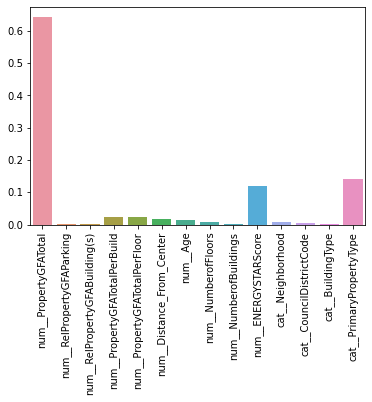

In [257]:
feature_importance = RandomForest_SEU_EN.best_estimator_.named_steps['model'].regressor_.feature_importances_
feature_names=get_feature_names(RandomForest_SEU_EN.best_estimator_.named_steps['preprocessor'])
sns.barplot(x=feature_names,y=feature_importance)
plt.xticks(rotation=90)

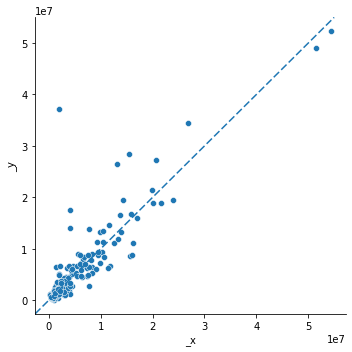

In [258]:
plot=sns.relplot(x=RandomForest_SEU_EN.predict(X_test_EN),y=y_test_EN['SiteEnergyUse(kBtu)'].values)
plot.ax.axline(xy1=(0,0),slope=1,dashes=(5,2))

###  TotalGHGEmissions

In [313]:
RandomForest_GHG_EN=search_RFR_ENERGYSTARScore.fit(X_train_EN, y_train_EN['TotalGHGEmissions'])
print('neg_mean_squared_error: %.3f' % RandomForest_GHG_EN.best_score_)
print('Config: %s' % RandomForest_GHG_EN.best_params_)

neg_mean_squared_error: -10718.590
Config: {'model__regressor__bootstrap': True, 'model__regressor__max_depth': 10, 'model__regressor__min_samples_leaf': 2, 'model__regressor__min_samples_split': 5}


In [314]:
print('r2_score:',pd.DataFrame(RandomForest_GHG_EN.cv_results_)[pd.DataFrame(RandomForest_GHG_EN.cv_results_)['rank_test_neg_mean_squared_error']==1][:1]['mean_test_r2'])

r2_score: 4    0.501276
Name: mean_test_r2, dtype: float64


C:\Users\Kfoury\AppData\Local\Temp/ipykernel_2164/1809191144.py:30: UserWarning: Transformer scaler (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'num__PropertyGFATotal'),
  Text(1, 0, 'num__RelPropertyGFAParking'),
  Text(2, 0, 'num__RelPropertyGFABuilding(s)'),
  Text(3, 0, 'num__PropertyGFATotalPerBuild'),
  Text(4, 0, 'num__PropertyGFATotalPerFloor'),
  Text(5, 0, 'num__Distance_From_Center'),
  Text(6, 0, 'num__Age'),
  Text(7, 0, 'num__NumberofFloors'),
  Text(8, 0, 'num__NumberofBuildings'),
  Text(9, 0, 'num__ENERGYSTARScore'),
  Text(10, 0, 'cat__Neighborhood'),
  Text(11, 0, 'cat__CouncilDistrictCode'),
  Text(12, 0, 'cat__BuildingType'),
  Text(13, 0, 'cat__PrimaryPropertyType')])

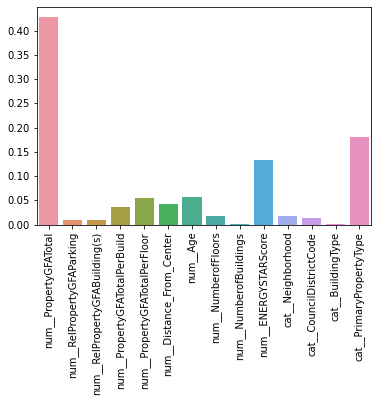

In [260]:
feature_importance = RandomForest_GHG_EN.best_estimator_.named_steps['model'].regressor_.feature_importances_
feature_names=get_feature_names(RandomForest_GHG_EN.best_estimator_.named_steps['preprocessor'])
sns.barplot(x=feature_names,y=feature_importance)
plt.xticks(rotation=90)

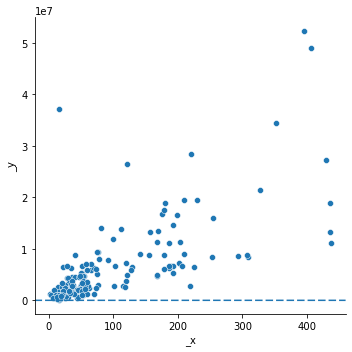

In [261]:
plot=sns.relplot(x=RandomForest_GHG_EN.predict(X_test_EN),y=y_test_EN['SiteEnergyUse(kBtu)'].values)
plot.ax.axline(xy1=(0,0),slope=1,dashes=(5,2))